In [1]:
# Stop warnings
import warnings
warnings.filterwarnings("ignore")

# Imports

import os
import sys
import json
import copy
import cortex
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt


import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


sys.path.append("{}/../../analysis_code/utils".format(os.getcwd()))
from plot_utils import *
from pycortex_utils import draw_cortex, set_pycortex_config_file, load_surface_pycortex, create_colormap, get_rois
from surface_utils import load_surface

In [2]:
# Import data base
main_dir = '/Users/uriel/disks/meso_shared'
project_dir = 'RetinoMaps'
suffix = 'Sac_Pur'

with open('../settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)
rois = analysis_info['rois']
subjects = analysis_info['subjects']
TR = analysis_info['TR']

# Bar plot 

## make Df 

In [18]:
# make all subject categorie proportions  df
rois_area_categorie_df = pd.DataFrame()
for subject in subjects :
    intertask_tsv_dir ='{}/{}/derivatives/pp_data/{}/{}/intertask/tsv'.format(
    main_dir, project_dir, subject, format_)
    data = pd.read_table('{}/{}_intertask-all_derivatives_{}.tsv'.format(intertask_tsv_dir, subject, suffix))
    subject_rois_area_categorie_df = pd.DataFrame()
    for roi in rois : 
        # Compute categorie proportions 
        roi_area = data.loc[data['roi'] == roi, 'vert_area'].sum()
        roi_area_saccade = data.loc[(data['roi'] == roi) & (data['saccade'] == 'saccade')].shape[0]
        roi_area_pursuit = data.loc[(data['roi'] == roi) & (data['pursuit'] == 'pursuit')].shape[0]
        roi_area_vision = data.loc[(data['roi'] == roi) & (data['vision'] == 'vision')].shape[0]
        roi_area_vision_and_pursuit_and_saccade = data.loc[(data['roi'] == roi) & (data['saccade'] == 'saccade') & (data['pursuit'] == 'pursuit') & (data['vision'] == 'vision'), 'vert_area'].shape[0]

        percent_saccade = ((roi_area_saccade * 100)/roi_area).round(1)
        percent_pursuit = ((roi_area_pursuit * 100)/roi_area).round(1)
        percent_vision = ((roi_area_vision * 100)/roi_area).round(1)
        percent_vision_and_pursuit_and_saccade = ((roi_area_vision_and_pursuit_and_saccade * 100)/roi_area).round(1)

        roi_area_categorie_df = pd.DataFrame({
                'subject':[subject],
                'roi': [roi],
                'saccade': [percent_saccade],
                'pursuit': [percent_pursuit],
                'vision': [percent_vision],
                'all': [percent_vision_and_pursuit_and_saccade]})


        subject_rois_area_categorie_df = pd.concat([subject_rois_area_categorie_df, roi_area_categorie_df], ignore_index=True)
    
    rois_area_categorie_df = pd.concat([rois_area_categorie_df, subject_rois_area_categorie_df], ignore_index=True)




In [19]:
# make group df 
median_df = rois_area_categorie_df.groupby(['roi'], sort=False).median(numeric_only=True).reset_index()
ci_low_df = rois_area_categorie_df.groupby(['roi'], sort=False).quantile(0.025, numeric_only=True).reset_index()
ci_high_df = rois_area_categorie_df.groupby(['roi'], sort=False).quantile(0.975, numeric_only=True).reset_index()

median_df = median_df.melt(id_vars=['roi'], 
                          value_vars=['saccade', 'pursuit', 'vision', 'all'],
                          var_name='categorie', 
                          value_name='median')

ci_low_df = ci_low_df.melt(id_vars=['roi'], 
                          value_vars=['saccade', 'pursuit', 'vision', 'all'],
                          var_name='categorie', 
                          value_name='ci_low')

ci_high_df = ci_high_df.melt(id_vars=['roi'], 
                          value_vars=['saccade', 'pursuit', 'vision', 'all'],
                          var_name='categorie', 
                          value_name='ci_high')


group_rois_area_categorie_df = pd.concat([median_df, ci_low_df.drop(columns=['roi', 'categorie']), ci_high_df.drop(columns=['roi', 'categorie'])], axis=1).reset_index(drop=True)


## make plot

### plot setting 

In [20]:
colormap_dict = {'V1': (243, 231, 155),
                 'V2': (250, 196, 132),
                 'V3': (248, 160, 126),
                 'V3AB': (235, 127, 134),
                 'LO': (150, 0, 90), 
                 'VO': (0, 0, 200),
                 'hMT+': (0, 25, 255),
                 'iIPS': (0, 152, 255),
                 'sIPS': (44, 255, 150),
                 'iPCS': (151, 255, 0),
                 'sPCS': (255, 234, 0),
                 'mPCS': (255, 111, 0)
                }
roi_colors = ['({},{},{})'.format(*rgb) for rgb in colormap_dict.values()]


roi_colors_dict = {'V1': 'rgb(243, 231, 155)', 
                   'V2': 'rgb(250, 196, 132)', 
                   'V3': 'rgb(248, 160, 126)', 
                   'V3AB': 'rgb(235, 127, 134)', 
                   'LO': 'rgb(150, 0, 90)',  
                   'VO': 'rgb(0, 0, 200)', 
                   'hMT+': 'rgb(0, 25, 255)', 
                   'iIPS': 'rgb(0, 152, 255)', 
                   'sIPS': 'rgb(44, 255, 150)', 
                   'iPCS': 'rgb(151, 255, 0)', 
                   'sPCS': 'rgb(255, 234, 0)', 
                   'mPCS': 'rgb(255, 111, 0)'}


In [21]:
# Template settings
template_specs = dict(axes_color="rgba(0, 0, 0, 1)",
                      axes_width=2,
                      axes_font_size=15,
                      bg_col="rgba(255, 255, 255, 1)",
                      font='Arial',
                      title_font_size=15,
                      plot_width=1.5)
fig_template = plotly_template(template_specs)

### plot

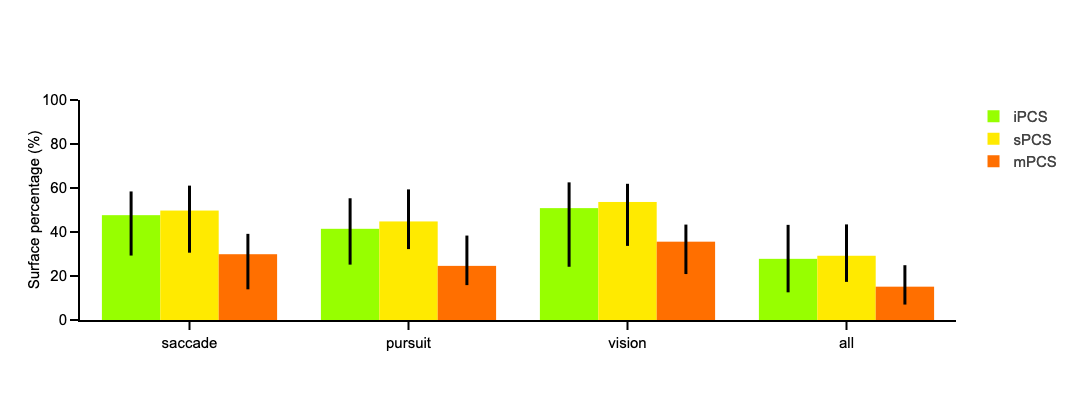

In [25]:
sub_rois =  ['iPCS', 'sPCS', 'mPCS']
fig = go.Figure()
for i, roi in enumerate(sub_rois):
    df_roi = group_rois_area_categorie_df.loc[group_rois_area_categorie_df['roi']==roi]
    fig.add_trace(go.Bar(
        x=df_roi['categorie'],
        y=df_roi['median'],
        name=roi,  
        marker=dict(color=roi_colors_dict[roi]), 
        error_y=dict(
            type='data',
            array=df_roi['ci_high'] - df_roi['median'], 
            arrayminus=df_roi['median'] - df_roi['ci_low'],  
            visible=True,
            thickness=3,
            width=0,
            color='black'
        ),
        showlegend=True
    ))
    
fig.update_xaxes(showline=True)
fig.update_yaxes(title='Surface percentage (%)', range=[0,100], showline=True)
fig.update_layout(template=fig_template, 
                  barmode='group', 
                  height=400, 
                  width=800)

fig.show()
fig.write_image("/Users/uriel/Downloads/Surface_percentage_4.pdf".format(subject))

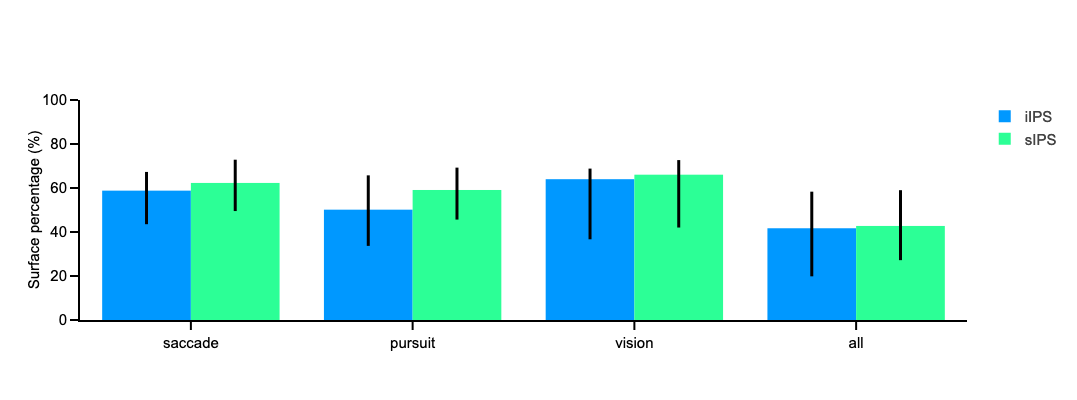

In [26]:
sub_rois =  ['iIPS', 'sIPS']
fig = go.Figure()
for i, roi in enumerate(sub_rois):
    df_roi = group_rois_area_categorie_df.loc[group_rois_area_categorie_df['roi']==roi]
    fig.add_trace(go.Bar(
        x=df_roi['categorie'],
        y=df_roi['median'],
        name=roi,  
        marker=dict(color=roi_colors_dict[roi]), 
        error_y=dict(
            type='data',
            array=df_roi['ci_high'] - df_roi['median'], 
            arrayminus=df_roi['median'] - df_roi['ci_low'],  
            visible=True,
            thickness=3,
            width=0,
            color='black'
        ),
        showlegend=True
    ))
    
fig.update_xaxes(showline=True)
fig.update_yaxes(title='Surface percentage (%)', range=[0,100], showline=True)
fig.update_layout(template=fig_template, 
                  barmode='group',
                  height=400, 
                  width=800)

fig.show()
fig.write_image("/Users/uriel/Downloads/Surface_percentage_3.pdf".format(subject))

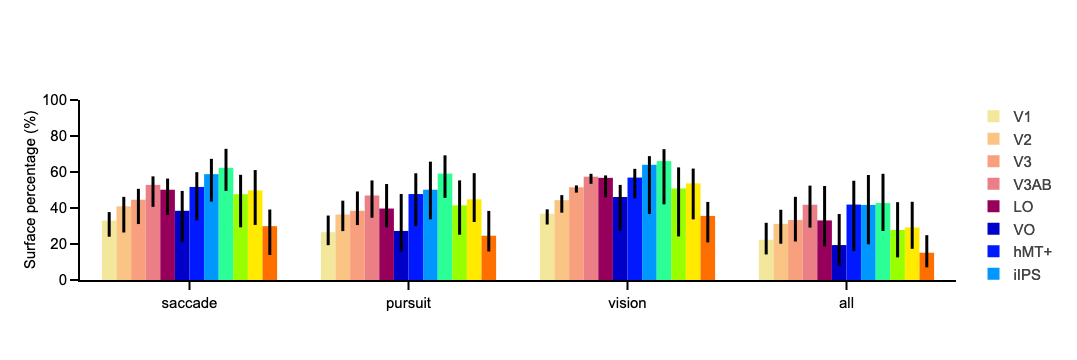

In [29]:
sub_rois =  ['V1', 'V2', 'V3', 'V3AB', 'LO', 'VO', 'hMT+', 'iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS']
fig = go.Figure()
for i, roi in enumerate(sub_rois):
    df_roi = group_rois_area_categorie_df.loc[group_rois_area_categorie_df['roi']==roi]
    fig.add_trace(go.Bar(
        x=df_roi['categorie'],
        y=df_roi['median'],
        name=roi,  
        marker=dict(color=roi_colors_dict[roi]), 
        error_y=dict(
            type='data',
            array=df_roi['ci_high'] - df_roi['median'], 
            arrayminus=df_roi['median'] - df_roi['ci_low'],  
            visible=True,
            thickness=3,
            width=0,
            color='black'
        ),
        showlegend=True
    ))
    
fig.update_xaxes(showline=True)
fig.update_yaxes(title='Surface percentage (%)', range=[0,100], showline=True)
fig.update_layout(template=fig_template, 
                  barmode='group')

fig.show()
fig.write_image("/Users/uriel/Downloads/Surface_percentage_5.pdf".format(subject))

In [52]:
df_roi

,roi,categorie,median,ci_low,ci_high
7,iIPS,saccade,58.80,43.5450,67.3025
8,sIPS,saccade,62.30,49.5225,72.8650
9,iPCS,saccade,47.65,29.2975,58.4350
10,sPCS,saccade,49.75,30.5950,61.0775
11,mPCS,saccade,29.90,13.9475,39.1575
19,iIPS,pursuit,50.15,33.6925,65.7500
20,sIPS,pursuit,59.10,45.6475,69.2600
21,iPCS,pursuit,41.45,25.1725,55.3375
22,sPCS,pursuit,44.80,32.2325,59.3625
23,mPCS,pursuit,24.60,15.8600,38.3825


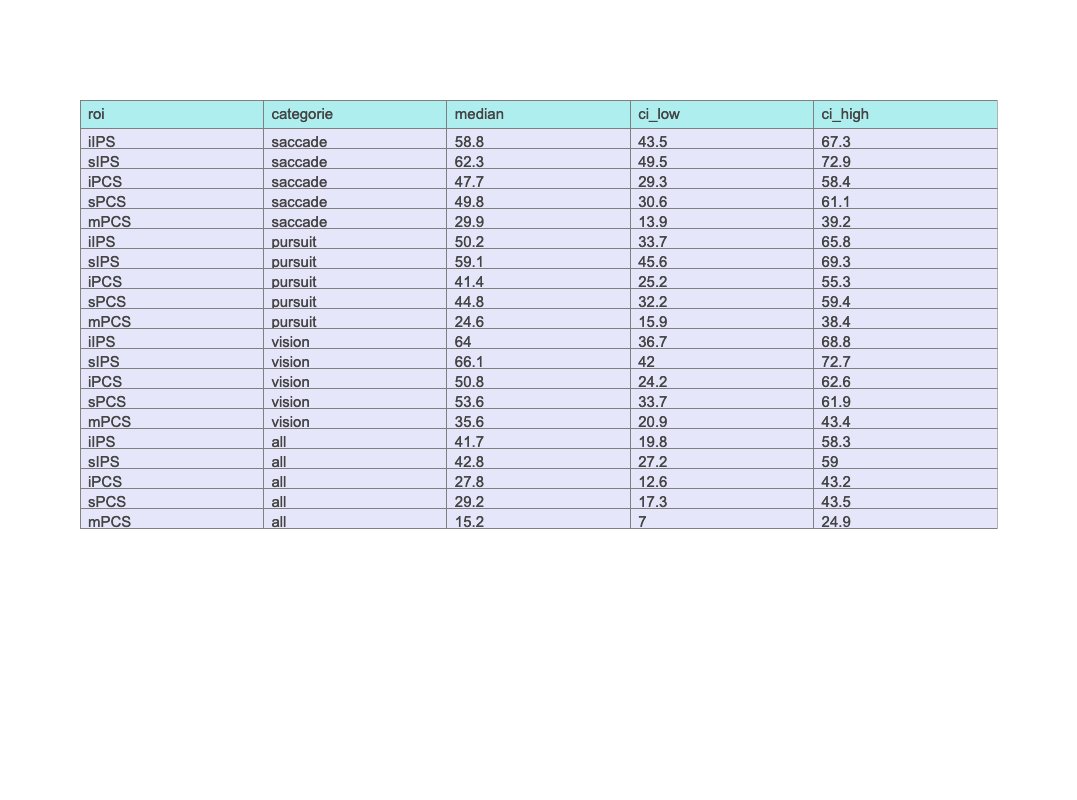

In [53]:
sub_rois =  ['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS']


df_roi = group_rois_area_categorie_df.loc[group_rois_area_categorie_df['roi'].isin(sub_rois)]


fig = go.Figure()
fig.add_trace(go.Table(header=dict(values=list(df_roi.columns), 
                                   fill_color='paleturquoise', 
                                   align='left'), 
                       cells=dict(values=[df_roi[col].round(1) for col in df_roi.columns], 
                                  fill_color='lavender', 
                                  align='left')
                      ))

fig.update_layout(template=fig_template,
                  height=800, 
                  width=800)
fig.write_image("/Users/uriel/Downloads/Surface_percentage_table.pdf".format(subject))
fig.show()

# pRF plots

## Figures settings

In [6]:
plot_groups = [['iIPS', 'sIPS'],['iPCS', 'sPCS', 'mPCS']]
fig_width = 1440
max_ecc = 15

# tresholds
ecc_th = [0, 15]
size_th= [0.1, 20]
rsq_th = [0, 1]
pcm_th = [0,20]


colormap_dict = {'V1': (243, 231, 155),
                 'V2': (250, 196, 132),
                 'V3': (248, 160, 126),
                 'V3AB': (235, 127, 134),
                 'LO': (150, 0, 90), 
                 'VO': (0, 0, 200),
                 'hMT+': (0, 25, 255),
                 'iIPS': (0, 152, 255),
                 'sIPS': (44, 255, 150),
                 'iPCS': (151, 255, 0),
                 'sPCS': (255, 234, 0),
                 'mPCS': (255, 111, 0)
                }
roi_colors = ['rgb({},{},{})'.format(*rgb) for rgb in colormap_dict.values()]

roi_colors_dict = {'V1': 'rgb(243, 231, 155)', 
                   'V2': 'rgb(250, 196, 132)', 
                   'V3': 'rgb(248, 160, 126)', 
                   'V3AB': 'rgb(235, 127, 134)', 
                   'LO': 'rgb(150, 0, 90)',  
                   'VO': 'rgb(0, 0, 200)', 
                   'hMT+': 'rgb(0, 25, 255)', 
                   'iIPS': 'rgb(0, 152, 255)', 
                   'sIPS': 'rgb(44, 255, 150)', 
                   'iPCS': 'rgb(151, 255, 0)', 
                   'sPCS': 'rgb(255, 234, 0)', 
                   'mPCS': 'rgb(255, 111, 0)'}

## Ecc size

In [132]:
def weighted_regression(x_reg, y_reg, weight_reg, model):
    """
    Function to compute regression parameter weighted by a matrix (e.g. r2 value),
    where the regression model is y = 1/(cx) + d.

    Parameters
    ----------
    x_reg : array (1D)
        x values to regress
    y_reg : array
        y values to regress
    weight_reg : array (1D) 
        weight values (0 to 1) for weighted regression
    model : str
        Type of regression model, either 'pcm' for the original model or 'linear' for a linear model.

    Returns
    -------
    coef_reg : float or array
        Regression coefficient(s) or parameter(s)
    intercept_reg : float or str
        Regression intercept or a parameter (or a string indicating no intercept)
    r_squared : float
        Coefficient of determination (R^2) value
    """

    import numpy as np
    from scipy.optimize import curve_fit
    from sklearn import linear_model
    from sklearn.metrics import r2_score

    x_reg = np.array(x_reg)
    y_reg = np.array(y_reg)
    weight_reg = np.array(weight_reg)

    # Filter out NaN values
    mask = (~np.isnan(x_reg) & ~np.isnan(y_reg))
    x_reg_nan = x_reg[mask]
    y_reg_nan = y_reg[mask]
    weight_reg_nan = weight_reg[mask]

    if model == 'pcm':
        # Define the model function
        def model_function(x, c, d):
            return 1 / (c * x + d)

        if weight_reg_nan.size >= 2:
            # Perform curve fitting
            params, _ = curve_fit(model_function, x_reg_nan, y_reg_nan, sigma=weight_reg_nan)
            c, d = params
            
            # Calculate predictions and R^2
            y_pred = model_function(x_reg_nan, c, d)
            r_squared = r2_score(y_reg_nan, y_pred, sample_weight=weight_reg_nan)
            
        else:
            c, d, r_squared = np.nan, np.nan, np.nan

        return c, d, r_squared

    elif model == 'linear':
        if weight_reg_nan.size >= 2:
            x_reg_nan = x_reg_nan.reshape(-1, 1)
            y_reg_nan = y_reg_nan.reshape(-1, 1)

            # Fit linear model
            regr = linear_model.LinearRegression()
            regr.fit(x_reg_nan, y_reg_nan, sample_weight=weight_reg_nan)
            coef_reg, intercept_reg = regr.coef_[0][0], regr.intercept_[0]

            # Calculate predictions and R^2
            y_pred = regr.predict(x_reg_nan)
            r_squared = r2_score(y_reg_nan, y_pred, sample_weight=weight_reg_nan)

        else:
            coef_reg, intercept_reg, r_squared = np.nan, np.nan, np.nan

        return coef_reg, intercept_reg, r_squared
    else:
        raise ValueError("Invalid model type. Supported models are 'pcm' and 'linear'.")


In [114]:
def prf_ecc_size_plot(df_ecc_size, fig_width, fig_height, rois, roi_colors, plot_groups, max_ecc):
    """
    Make scatter plot for linear relationship between eccentricity and size

    Parameters
    ----------
    df_ecc_size : A data dataframe
    fig_width : figure width in pixels
    fig_height : figure height in pixels
    rois : list of rois
    roi_colors : list of rgb colors for plotly
    plot_groups : groups of roi to plot together
    max_ecc : maximum eccentricity 
    
    Returns
    -------
    fig : eccentricy as a function of size plot
    """
    
    # from maths_utils import weighted_regression

    # General figure settings
    template_specs = dict(axes_color="rgba(0, 0, 0, 1)",
                          axes_width=2,
                          axes_font_size=15,
                          bg_col="rgba(255, 255, 255, 1)",
                          font='Arial',
                          title_font_size=15,
                          plot_width=1.5)
    
    # General figure settings
    fig_template = plotly_template(template_specs)

    # General settings
    rows, cols = 1, len(plot_groups)
    fig = make_subplots(rows=rows, cols=cols, print_grid=False)
    r_squared_df = pd.DataFrame()
    for l, line_label in enumerate(plot_groups):
        for j, roi in enumerate(line_label):
            r_squared_df_roi = pd.DataFrame()
            
            # Parametring colors
            roi_color = roi_colors[roi]
            roi_color_opac = f"rgba{roi_color[3:-1]}, 0.15)"
            
            # Get data
            df = df_ecc_size.loc[(df_ecc_size.roi == roi)]
            ecc_median = np.array(df.prf_ecc_bins)
            size_median = np.array(df.prf_size_bins_median)
            r2_median = np.array(df.prf_loo_r2_bins_median)
            size_upper_bound = np.array(df.prf_size_bins_ci_upper_bound)
            size_lower_bound = np.array(df.prf_size_bins_ci_lower_bound)
            
            # Linear regression
            slope, intercept, r_squared = weighted_regression(ecc_median, size_median, r2_median, model='linear')
            slope_upper, intercept_upper, r_squared_upper = weighted_regression(ecc_median[np.where(~np.isnan(size_upper_bound))], 
                                                               size_upper_bound[~np.isnan(size_upper_bound)], 
                                                               r2_median[np.where(~np.isnan(size_upper_bound))], 
                                                               model='linear')
            
            slope_lower, intercept_lower, r_squared_lower = weighted_regression(ecc_median[np.where(~np.isnan(size_lower_bound))], 
                                                               size_lower_bound[~np.isnan(size_lower_bound)], 
                                                               r2_median[np.where(~np.isnan(size_lower_bound))], 
                                                               model='linear')

            line_x = np.linspace(ecc_median[0], ecc_median[-1], 50)
            line = slope * line_x + intercept
            line_upper = slope_upper * line_x + intercept_upper
            line_lower = slope_lower * line_x + intercept_lower

            fig.add_trace(go.Scatter(x=line_x, y=line, mode='lines', name=roi, legendgroup=roi, 
                                      line=dict(color=roi_color, width=3), showlegend=False), 
                          row=1, col=l+1)

            # Error area
            fig.add_trace(go.Scatter(x=np.concatenate([line_x, line_x[::-1]]), 
                                      y=np.concatenate([list(line_upper), list(line_lower[::-1])]), 
                                      mode='lines', fill='toself', fillcolor=roi_color_opac, 
                                      line=dict(color=roi_color_opac, width=0), showlegend=False), 
                          row=1, col=l+1)

            # Markers
            fig.add_trace(go.Scatter(x=ecc_median, 
                                     y=size_median, mode='markers', 
                                     error_y=dict(type='data', 
                                                  array=size_upper_bound - size_median, 
                                                  arrayminus=size_median - size_lower_bound,
                                                  visible=True, 
                                                  thickness=3, 
                                                  width=0, 
                                                  color=roi_color),
                                      marker=dict(color=roi_color,
                                                  symbol='square',
                                                  size=8, 
                                                  line=dict(color=roi_color, 
                                                            width=3)), 
                                      showlegend=False), 
                          row=1, col=l + 1)
            
            # Add legend
            annotation = go.layout.Annotation(x=1, y=max_ecc-j*1.5, text=roi, xanchor='left',
                                              showarrow=False, font_color=roi_color, 
                                              font_family=template_specs['font'],
                                              font_size=template_specs['axes_font_size'],
                                             )
            fig.add_annotation(annotation, row=1, col=l+1)
            
            r_squared_df_roi['roi'] = [roi] 
            r_squared_df_roi['r_squared'] = [r_squared]
            r_squared_df_roi['r_squared_upper'] = [r_squared_upper]
            r_squared_df_roi['r_squared_lower'] = [r_squared_lower]
            rsquared_df = pd.concat([r_squared_df, r_squared_df_roi], ignore_index=True)
            
        # Set axis titles only for the left-most column and bottom-most row
        fig.update_yaxes(title_text='pRF size (dva)', row=1, col=1)
        fig.update_xaxes(title_text='pRF eccentricity (dva)', range=[0, max_ecc], showline=True, row=1, col=l+1)
        fig.update_yaxes(range=[0, max_ecc], showline=True)
        fig.update_layout(height=fig_height, width=fig_width, showlegend=False, template=fig_template,
                         margin_l=100, margin_r=50, margin_t=50, margin_b=100)
        


        
    return fig, r_squared_df

In [115]:
subject = 'group'
format_ = '170k'
intertask_all_tsv_dir ='{}/{}/derivatives/pp_data/{}/{}/intertask/tsv/tsv_vision_and_pursuit_and_saccade'.format(main_dir, project_dir, subject, format_)

df_ecc_size = pd.read_table('{}/{}_vision_and_pursuit_and_saccade_prf_ecc_size_{}.tsv'.format(intertask_all_tsv_dir,subject, suffix))


In [162]:
df_ecc_size_2 = pd.DataFrame(np.random.rand(*df_ecc_size.shape), columns=df_ecc_size.columns)

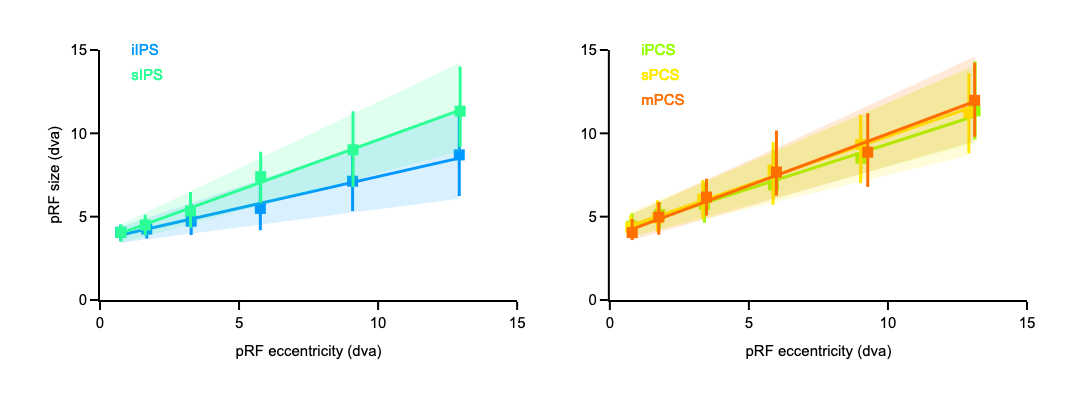

In [183]:
rois = ['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS']
fig, r_squared_df_ecc_size = prf_ecc_size_plot(df_ecc_size=df_ecc_size, fig_width=fig_width, 
                        fig_height=400, rois=rois, roi_colors=roi_colors_dict,
                        plot_groups=plot_groups, max_ecc=max_ecc)

fig.show()
fig.write_image("/Users/uriel/Downloads/{}_ecc_size.pdf".format(subject))

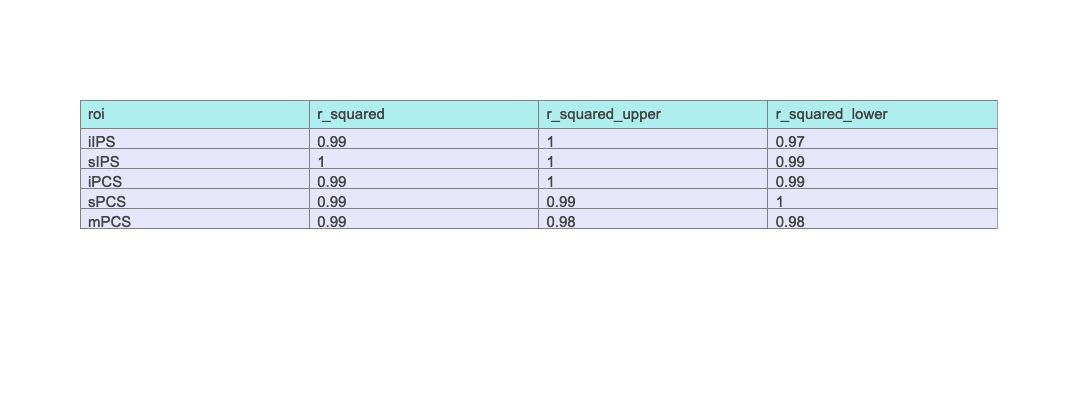

In [185]:
fig = go.Figure()
fig.add_trace(go.Table(header=dict(values=list(r_squared_df_ecc_size.columns), 
                                   fill_color='paleturquoise', 
                                   align='left'), 
                       cells=dict(values=[r_squared_df_ecc_size[col].round(2) for col in r_squared_df_ecc_size.columns], 
                                  fill_color='lavender', 
                                  align='left')
                      ))

fig.update_layout(template=fig_template,
                  height=400, 
                  width=800)
fig.write_image("/Users/uriel/Downloads/ecc_size_r2.pdf".format(subject))
fig.show()

## Ecc pRF CM

In [187]:
def prf_ecc_pcm_plot(df_ecc_pcm, fig_width, fig_height, rois, roi_colors, plot_groups, max_ecc):
    """
    Make scatter plot for relationship between eccentricity and pCM

    Parameters
    ----------
    df_ecc_pcm : dataframe for the plot
    fig_width : figure width in pixels
    fig_height : figure height in pixels
    rois : list of rois
    roi_colors : list of rgb colors for plotly
    plot_groups : groups of roi to plot together
    max_ecc : maximum eccentricity
    
    Returns
    -------
    fig : eccentricy as a function of pcm plot
    """

    # from maths_utils import weighted_regression
    
    # General figure settings
    template_specs = dict(axes_color="rgba(0, 0, 0, 1)",
                          axes_width=2,
                          axes_font_size=15,
                          bg_col="rgba(255, 255, 255, 1)",
                          font='Arial',
                          title_font_size=15,
                          plot_width=1.5)
    
    # General figure settings
    fig_template = plotly_template(template_specs)

    # General settings
    rows, cols = 1, len(plot_groups)
    fig = make_subplots(rows=rows, cols=cols, print_grid=False)
    r_squared_df = pd.DataFrame()
    for l, line_label in enumerate(plot_groups):
        for j, roi in enumerate(line_label):
            r_squared_df_roi = pd.DataFrame()

            # Parametring colors
            roi_color = roi_colors[roi]
            roi_color_opac = f"rgba{roi_color[3:-1]}, 0.15)"
            
            # Get data
            df = df_ecc_pcm.loc[(df_ecc_pcm.roi == roi)]
            ecc_median = np.array(df.prf_ecc_bins)
            pcm_median = np.array(df.prf_pcm_bins_median)
            r2_median = np.array(df.prf_loo_r2_bins_median)
            pcm_upper_bound = np.array(df.prf_pcm_bins_ci_upper_bound)
            pcm_lower_bound = np.array(df.prf_pcm_bins_ci_lower_bound)
            
            # Linear regression
            slope, intercept, r_squared = weighted_regression(ecc_median, pcm_median, r2_median, model='pcm')
            
            slope_upper, intercept_upper, r_squared_upper = weighted_regression(ecc_median[~np.isnan(pcm_upper_bound)], 
                                                               pcm_upper_bound[~np.isnan(pcm_upper_bound)], 
                                                               r2_median[~np.isnan(pcm_upper_bound)], 
                                                               model='pcm')
            
            slope_lower, intercept_lower, r_squared_lower = weighted_regression(ecc_median[~np.isnan(pcm_lower_bound)], 
                                                               pcm_lower_bound[~np.isnan(pcm_lower_bound)], 
                                                               r2_median[~np.isnan(pcm_lower_bound)], 
                                                               model='pcm')

            line_x = np.linspace(ecc_median[0], ecc_median[-1], 50)
            line = 1 / (slope * line_x + intercept)
            line_upper = 1 / (slope_upper * line_x + intercept_upper)
            line_lower = 1 / (slope_lower * line_x + intercept_lower)

            fig.add_trace(go.Scatter(x=line_x, 
                                     y=line, 
                                     mode='lines', 
                                     name=roi, 
                                     legendgroup=roi, 
                                     line=dict(color=roi_color, width=3), 
                                     showlegend=False), 
                          row=1, col=l+1)

            # Error area
            fig.add_trace(go.Scatter(x=np.concatenate([line_x, line_x[::-1]]),
                                      y=np.concatenate([list(line_upper), list(line_lower[::-1])]), 
                                      mode='lines', fill='toself', fillcolor=roi_color_opac, 
                                      line=dict(color=roi_color_opac, width=0), showlegend=False), 
                          row=1, col=l+1)

            # Markers
            fig.add_trace(go.Scatter(x=ecc_median, 
                                     y=pcm_median, 
                                     mode='markers', 
                                     error_y=dict(type='data', 
                                                  array=pcm_upper_bound - pcm_median, 
                                                  arrayminus=pcm_median - pcm_lower_bound,
                                                  visible=True, 
                                                  thickness=3, 
                                                  width=0, 
                                                  color=roi_color),
                                     marker=dict(color=roi_color, 
                                                 symbol='square',
                                                 size=8, line=dict(color=roi_color,
                                                                   width=3)), 
                                     showlegend=False), 
                          row=1, col=l + 1)
            
            # Add legend
            annotation = go.layout.Annotation(x=12, y=(20)-j*2, text=roi, xanchor='left',
                                              showarrow=False, font_color=roi_color, 
                                              font_family=template_specs['font'],
                                              font_size=template_specs['axes_font_size'],
                                             )
            fig.add_annotation(annotation, row=1, col=l+1)
            
            r_squared_df_roi['roi'] = [roi] 
            r_squared_df_roi['r_squared'] = [r_squared]
            r_squared_df_roi['r_squared_upper'] = [r_squared_upper]
            r_squared_df_roi['r_squared_lower'] = [r_squared_lower]
            r_squared_df = pd.concat([r_squared_df, r_squared_df_roi], ignore_index=True)

        # Set axis titles only for the left-most column and bottom-most row
        fig.update_yaxes(title_text='pRF cortical magn. (mm/dva)', row=1, col=1)
        fig.update_xaxes(title_text='pRF eccentricity (dva)', range=[0, max_ecc], showline=True, row=1, col=l+1)
        fig.update_yaxes(range=[0, 20], showline=True)
        fig.update_layout(height=fig_height, width=fig_width, showlegend=False, template=fig_template,
                         margin_l=100, margin_r=50, margin_t=50, margin_b=100)
        
    return fig, r_squared_df

In [189]:
df_ecc_pcm = pd.read_table('{}/{}_vision_and_pursuit_and_saccade_prf_ecc_pcm_{}.tsv'.format(intertask_all_tsv_dir,subject, suffix))

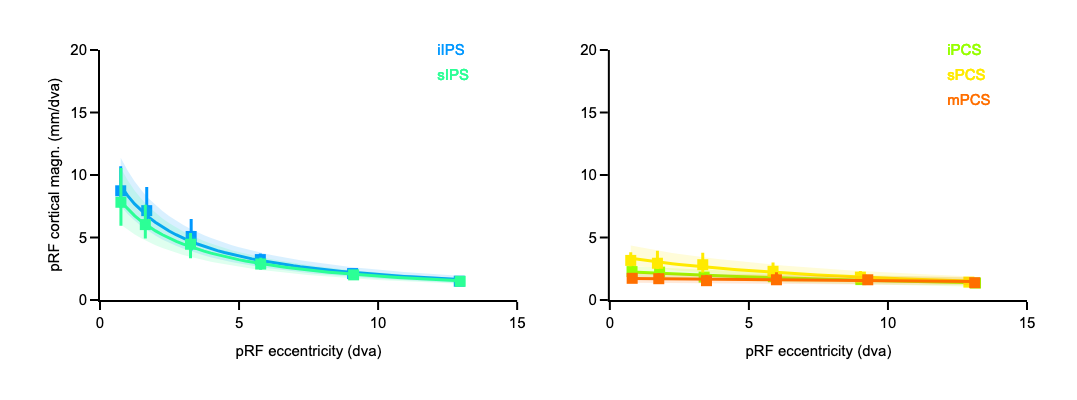

In [191]:
fig2, rsquared_df_pcm_size = prf_ecc_pcm_plot(df_ecc_pcm=df_ecc_pcm, fig_width=fig_width, fig_height=400, 
                        rois=rois, roi_colors=roi_colors_dict,
                        plot_groups=plot_groups, max_ecc=max_ecc)

fig2.show()
fig2.write_image("/Users/uriel/Downloads/{}_ecc_pcm.pdf".format(subject))

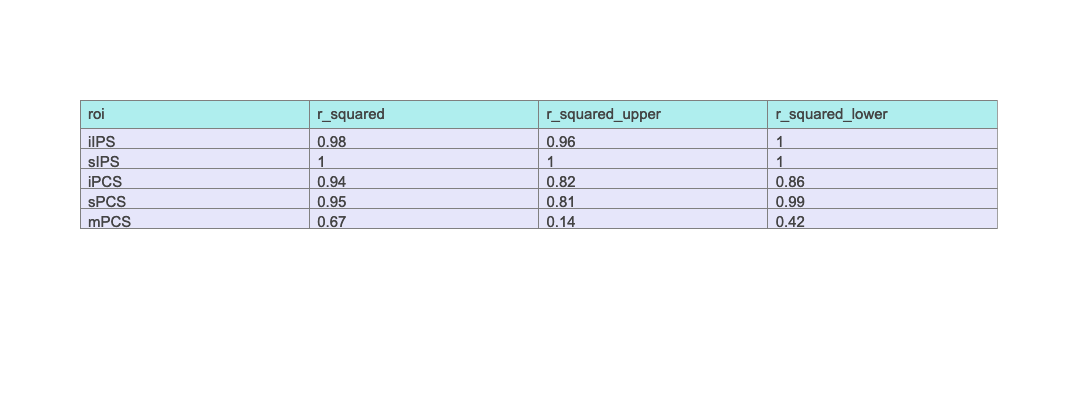

In [193]:
fig = go.Figure()
fig.add_trace(go.Table(header=dict(values=list(rsquared_df_pcm_size.columns), 
                                   fill_color='paleturquoise', 
                                   align='left'), 
                       cells=dict(values=[rsquared_df_pcm_size[col].round(2) for col in rsquared_df_pcm_size.columns], 
                                  fill_color='lavender', 
                                  align='left')
                      ))

fig.update_layout(template=fig_template,
                  height=400, 
                  width=800)
fig.write_image("/Users/uriel/Downloads/ecc_pcm_r2.pdf".format(subject))
fig.show()

# Pycortex maps roi 

##  intertask

In [88]:
subject = 'sub-12'
pycortex_subject = 'sub-170k'
format_ = '170k'
extension = 'dtseries.nii'
prf_task_name = analysis_info['prf_task_name']
alpha_range = analysis_info["alpha_range"]
group_tasks = analysis_info['task_intertask']
flatmaps_dir = '/Users/uriel/Downloads/'

# Maps settings
all_idx, pur_idx, sac_idx, pur_sac_idx, prf_idx, prf_pur_idx, prf_sac_idx, \
        prf_pur_sac_idx = 0,1,2,3,4,5,6,7

slope_idx, intercept_idx, rvalue_idx, pvalue_idx, stderr_idx, \
    trs_idx, corr_pvalue_5pt_idx, corr_pvalue_1pt_idx = 0, 1, 2, 3, 4, 5, 6, 7

# Set pycortex db and colormaps
cortex_dir = "{}/{}/derivatives/pp_data/cortex".format(main_dir, project_dir)
set_pycortex_config_file(cortex_dir)

# Define/create colormap
colormap_name = 'stats_colors'
colormap_dict = {'n/a': (255, 255, 255),
                 'Pursuit':  (227, 119, 194),
                 'Saccade': (140, 86, 75),
                 'Pursuit_and_Saccade': (148, 103, 189),
                 'Vision': (214, 39, 40),
                 'Vision_and_Pursuit': (44, 160, 44), 
                 'Vision_and_Saccade': (255, 127, 14),
                 'Vision_and_Pursuit_and_Saccade': (31, 119, 180)}
create_colormap(cortex_dir=cortex_dir, 
                colormap_name=colormap_name, 
                colormap_dict=colormap_dict)

suffix = 'Sac_Pur'
sac_task = 'SacVELoc'
pur_task = 'PurVELoc'

# Define directories and fn
intertask_dir = "{}/{}/derivatives/pp_data/{}/{}/intertask".format(
    main_dir, project_dir, subject,format_)
prf_stats_dir = "{}/{}/derivatives/pp_data/{}/{}/prf/prf_derivatives".format(
    main_dir, project_dir, subject,format_)
glm_stats_dir = "{}/{}/derivatives/pp_data/{}/{}/glm/glm_derivatives".format(
    main_dir, project_dir,  subject,format_)

stats_avg_fn = '{}/{}_intertask_{}.dtseries.nii'.format(
    intertask_dir, subject, suffix)
prf_stats_avg_fn = '{}/{}_task-{}_fmriprep_dct_avg_prf-stats_loo-median.dtseries.nii'.format(
    prf_stats_dir, subject, prf_task_name)
sac_stats_avg_fn = '{}/{}_task-{}_fmriprep_dct_avg_glm-stats_loo-median.dtseries.nii'.format(
    glm_stats_dir, subject, sac_task)
pur_stats_avg_fn = '{}/{}_task-{}_fmriprep_dct_avg_glm-stats_loo-median.dtseries.nii'.format(
    glm_stats_dir, subject, pur_task)

#  Load data
results_stats = load_surface_pycortex(brain_fn=stats_avg_fn)
intertask_mat = results_stats['data_concat']

results_prf = load_surface_pycortex(brain_fn=prf_stats_avg_fn)
prf_mat = results_prf['data_concat']

results_sac = load_surface_pycortex(brain_fn=sac_stats_avg_fn)
sac_mat = results_sac['data_concat']

results_pur = load_surface_pycortex(brain_fn=pur_stats_avg_fn)
pur_mat = results_pur['data_concat']

if subject == 'sub-170k': save_svg = save_svg
else: save_svg = False


# Compute R2 from R
prf_mat[rvalue_idx,:] =  prf_mat[rvalue_idx,:]**2
sac_mat[rvalue_idx,:] = sac_mat[rvalue_idx,:]**2
pur_mat[rvalue_idx,:] = pur_mat[rvalue_idx,:]**2

# threshold data
# pRF
prf_mat_corrected = copy.copy(prf_mat)
prf_mat_corrected_th = prf_mat_corrected
if analysis_info['stats_th'] == 0.05: stats_th_down = prf_mat_corrected_th[corr_pvalue_5pt_idx,...] <= 0.05
elif analysis_info['stats_th'] == 0.01: stats_th_down = prf_mat_corrected_th[corr_pvalue_1pt_idx,...] <= 0.01
prf_mat_corrected[rvalue_idx, stats_th_down==False]=0 # put this to zero to not plot it

# SacLoc        
sac_mat_corrected = copy.copy(sac_mat)
sac_mat_corrected_th = sac_mat_corrected
if analysis_info['stats_th'] == 0.05: stats_th_down = sac_mat_corrected_th[corr_pvalue_5pt_idx,...] <= 0.05
elif analysis_info['stats_th'] == 0.01: stats_th_down = sac_mat_corrected_th[corr_pvalue_1pt_idx,...] <= 0.01
sac_mat_corrected[rvalue_idx, stats_th_down==False]=0 # put this to zero to not plot it

# PurLoc        
pur_mat_corrected = copy.copy(pur_mat)
pur_mat_corrected_th = pur_mat_corrected
if analysis_info['stats_th'] == 0.05: stats_th_down = pur_mat_corrected_th[corr_pvalue_5pt_idx,...] <= 0.05
elif analysis_info['stats_th'] == 0.01: stats_th_down = pur_mat_corrected_th[corr_pvalue_1pt_idx,...] <= 0.01
pur_mat_corrected[rvalue_idx, stats_th_down==False]=0 # put this to zero to not plot it

#  Creat R2 for the all flatmap
rsq_all = np.zeros((intertask_mat[all_idx,...].shape))
for vert, categorie in enumerate(intertask_mat[all_idx,...]):
    if categorie == 1: rsq_all[vert] = pur_mat_corrected[rvalue_idx,vert]

    elif categorie == 2: rsq_all[vert] = sac_mat_corrected[rvalue_idx,vert]

    elif categorie == 3: rsq_all[vert] = np.nanmedian([pur_mat_corrected[rvalue_idx,vert], 
                                                     sac_mat_corrected[rvalue_idx,vert]],
                                                    axis=0)

    elif categorie == 4: rsq_all[vert] = prf_mat_corrected[rvalue_idx,vert]

    elif categorie == 5: rsq_all[vert] = np.nanmedian([prf_mat_corrected[rvalue_idx,vert], 
                                                     pur_mat_corrected[rvalue_idx,vert]],
                                                    axis=0)

    elif categorie == 6: rsq_all[vert] = np.nanmedian([prf_mat_corrected[rvalue_idx,vert], 
                                                     sac_mat_corrected[rvalue_idx,vert]],
                                                    axis=0)

    elif categorie == 7: rsq_all[vert] = np.nanmedian([prf_mat_corrected[rvalue_idx,vert], 
                                                      sac_mat_corrected[rvalue_idx,vert], 
                                                      pur_mat_corrected[rvalue_idx,vert]], 
                                                    axis=0)

#  Creat R2 for the pur_sac flatmap       
rsq_pur_sac = np.zeros((intertask_mat[pur_sac_idx,...].shape))
for vert, categorie in enumerate(intertask_mat[pur_sac_idx,...]):
    if categorie == 3: rsq_pur_sac[vert] = np.nanmedian([pur_mat_corrected[rvalue_idx,vert], 
                                                       sac_mat_corrected[rvalue_idx,vert]], 
                                                      axis=0)

#  Creat R2 for the prf_pur flatmap               
rsq_prf_pur = np.zeros((intertask_mat[prf_pur_idx,...].shape))
for vert, categorie in enumerate(intertask_mat[prf_pur_idx,...]):
    if categorie == 5: rsq_prf_pur[vert] = np.nanmedian([pur_mat_corrected[rvalue_idx,vert], 
                                                       sac_mat_corrected[rvalue_idx,vert]], 
                                                      axis=0)

#  Creat R2 for the prf_sac flatmap               
rsq_prf_sac = np.zeros((intertask_mat[prf_sac_idx,...].shape))
for vert, categorie in enumerate(intertask_mat[prf_sac_idx,...]):
    if categorie == 6: rsq_prf_sac[vert] = np.nanmedian([prf_mat_corrected[rvalue_idx,vert], 
                                                       sac_mat_corrected[rvalue_idx,vert]], 
                                                      axis=0)

#  Creat R2 for the prf_pur_sac flatmap               
rsq_prf_pur_sac = np.zeros((intertask_mat[all_idx,...].shape))
for vert, categorie in enumerate(intertask_mat[all_idx,...]):
    if categorie == 7: rsq_prf_pur_sac[vert] = np.nanmean([prf_mat[rvalue_idx,vert], 
                                                           sac_mat_corrected[rvalue_idx,vert], 
                                                           pur_mat_corrected[rvalue_idx,vert]], 
                                                          axis=0)

# Create flatmaps  
print('Creating flatmaps...')
maps_names = []      

# get roi mask 
rois_dic = get_rois(subject='sub-12', return_concat_hemis=True, return_hemi=None, rois=None, mask=True, atlas_name='mmp_group', surf_size='59k')
frontal_mask = rois_dic['iPCS'] | rois_dic['sPCS'] | rois_dic['mPCS']
parietal_mask = rois_dic['iIPS'] | rois_dic['sIPS']

#  Creat the all flatmap frontal areas 
alpha_all = (rsq_all - alpha_range[0])/(alpha_range[1]-alpha_range[0])
alpha_all[alpha_all>1]=1
alpha_all[~frontal_mask] = 0


intertask_data_all = intertask_mat[all_idx,...]
alpha_all[intertask_data_all == 0] = 0
param_all_frontal = {'data': intertask_data_all, 
             'cmap': colormap_name, 
             'alpha': alpha_all, 
             'vmin': 0, 
             'vmax': 7, 
             'cbar': 'discrete_personalized', 
             'cmap_steps': len(colormap_dict),
             'cmap_dict': colormap_dict,
             'cortex_type': 'VertexRGB', 
             'description': 'intertask map', 
             'curv_brightness': 0.1, 
             'curv_contrast': 0.25, 
             'add_roi': save_svg, 
             'cbar_label': '', 
             'with_labels': True}
maps_names.append('all_frontal')

#  Creat the all flatmap parietal areas 
alpha_all = (rsq_all - alpha_range[0])/(alpha_range[1]-alpha_range[0])
alpha_all[alpha_all>1]=1
alpha_all[~parietal_mask] = 0


intertask_data_all = intertask_mat[all_idx,...]
alpha_all[intertask_data_all == 0] = 0
param_all_parietal = {'data': intertask_data_all, 
             'cmap': colormap_name, 
             'alpha': alpha_all, 
             'vmin': 0, 
             'vmax': 7, 
             'cbar': 'discrete_personalized', 
             'cmap_steps': len(colormap_dict),
             'cmap_dict': colormap_dict,
             'cortex_type': 'VertexRGB', 
             'description': 'intertask map', 
             'curv_brightness': 0.1, 
             'curv_contrast': 0.25, 
             'add_roi': save_svg, 
             'cbar_label': '', 
             'with_labels': True}
maps_names.append('all_parietal')

# draw flatmaps
volumes = {}
for maps_name in maps_names:

    # create flatmap
    roi_name = '{}'.format(maps_name)
    roi_param = {'subject': pycortex_subject, 'xfmname': None, 'roi_name': roi_name}
    print(roi_name)
    exec('param_{}.update(roi_param)'.format(maps_name))
    exec('volume_{maps_name} = draw_cortex(**param_{maps_name})'.format(maps_name = maps_name))
    exec("plt.savefig('{}/{}_{}_{}.pdf')".format(flatmaps_dir, subject, maps_name, suffix))
    plt.close()





Creating flatmaps...
all_frontal
all_parietal


In [90]:
frontal_mask = rois_dic['iPCS'] | rois_dic['sPCS'] | rois_dic['mPCS']
parietal_mask = rois_dic['iIPS'] | rois_dic['sIPS']

masks = {'frontal_mask':frontal_mask, 'parietal_mask':parietal_mask}

In [94]:
for mask in masks.keys():
    print(mask)

frontal_mask
parietal_mask


In [96]:
mask

'parietal_mask'

## pRF

In [103]:
flatmaps_dir = '/Users/uriel/Downloads/'


prf_task_name = analysis_info['prf_task_name']
maps_names_css = analysis_info['maps_names_css']
maps_names_pcm = analysis_info['maps_names_pcm']
maps_names_css_stats = analysis_info['maps_names_css_stats']


frontal_mask = rois_dic['iPCS'] | rois_dic['sPCS'] | rois_dic['mPCS']
parietal_mask = rois_dic['iIPS'] | rois_dic['sIPS']

masks = {'frontal_mask':frontal_mask, 'parietal_mask':parietal_mask}

for mask in masks.keys():
    rois_mask = masks[mask]
    # Maps settings 
    for idx, col_name in enumerate(maps_names_css + maps_names_css_stats + maps_names_pcm):
        exec("{}_idx = idx".format(col_name))

    cmap_polar, cmap_uni, cmap_ecc_size = 'hsv', 'Reds', 'Spectral'
    col_offset = 1.0/14.0
    cmap_steps = 255

    # plot scales
    rsq_scale = [0, 1]
    ecc_scale = [0, 8]
    size_scale = [0, 5]
    n_scale = [0, 2]
    pcm_scale = [0, 10]

    # Define directories and fn
    prf_dir = "{}/{}/derivatives/pp_data/{}/{}/prf".format(main_dir, project_dir, subject, format_)
    prf_deriv_dir = "{}/prf_derivatives".format(prf_dir)



    # Derivatives
    deriv_median_fn = '{}/{}_task-{}_fmriprep_dct_avg_prf-deriv_css_loo-median.dtseries.nii'.format(
        prf_deriv_dir, subject, prf_task_name)
    deriv_results = load_surface_pycortex(brain_fn=deriv_median_fn)
    deriv_mat = deriv_results['data_concat']

    # Stats
    stats_median_fn = '{}/{}_task-{}_fmriprep_dct_avg_prf-stats_loo-median.dtseries.nii'.format(
        prf_deriv_dir, subject, prf_task_name)
    stats_results = load_surface_pycortex(brain_fn=stats_median_fn)
    stats_mat = stats_results['data_concat']

    # pRF CM
    pcm_median_fn = '{}/{}_task-{}_fmriprep_dct_avg_prf-pcm_css_loo-median.dtseries.nii'.format(
        prf_deriv_dir, subject, prf_task_name)
    pcm_results = load_surface_pycortex(brain_fn=pcm_median_fn)
    pcm_mat = pcm_results['data_concat']

    # Combine mat
    all_deriv_mat = np.concatenate((deriv_mat, stats_mat, pcm_mat))

    # Threshold mat
    all_deriv_mat_th = all_deriv_mat
    amp_down = all_deriv_mat_th[amplitude_idx,...] > 0
    rsq_down = all_deriv_mat_th[prf_loo_r2_idx,...] >= analysis_info['rsqr_th']
    size_th_down = all_deriv_mat_th[prf_size_idx,...] >= analysis_info['size_th'][0]
    size_th_up = all_deriv_mat_th[prf_size_idx,...] <= analysis_info['size_th'][1]
    ecc_th_down = all_deriv_mat_th[prf_ecc_idx,...] >= analysis_info['ecc_th'][0]
    ecc_th_up = all_deriv_mat_th[prf_ecc_idx,...] <= analysis_info['ecc_th'][1]
    n_th_down = all_deriv_mat_th[prf_n_idx,...] >= analysis_info['n_th'][0]
    n_th_up = all_deriv_mat_th[prf_n_idx,...] <= analysis_info['n_th'][1]
    if analysis_info['stats_th'] == 0.05: stats_th_down = all_deriv_mat_th[corr_pvalue_5pt_idx,...] <= 0.05
    elif analysis_info['stats_th'] == 0.01: stats_th_down = all_deriv_mat_th[corr_pvalue_1pt_idx,...] <= 0.01
    all_th = np.array((amp_down,
                       rsq_down,
                       size_th_down,size_th_up, 
                       ecc_th_down, ecc_th_up,
                       n_th_down, n_th_up,
                       stats_th_down
                      )) 
    all_deriv_mat[prf_loo_r2_idx, np.logical_and.reduce(all_th)==False]=0 # put this to zero to not plot it

    # Create flatmaps
    maps_names = []

    # Loo r-square and alpha
    loo_rsq_data = all_deriv_mat[prf_loo_r2_idx,...]
    alpha = loo_rsq_data
    alpha_range = analysis_info["alpha_range"]
    alpha = (alpha - alpha_range[0]) / (alpha_range[1] - alpha_range[0])
    alpha[alpha>1]=1
    alpha[~rois_mask] = 0

    param_loo_rsq = {'data': loo_rsq_data, 
                     'cmap': cmap_uni, 
                     'alpha': alpha, 
                     'vmin': rsq_scale[0], 
                     'vmax': rsq_scale[1], 
                     'cbar': 'discrete', 
                     'cortex_type': 'VertexRGB',
                     'description': 'CSS pRF LOO R2',
                     'curv_brightness':1,
                     'curv_contrast': 0.1,
                     'add_roi': save_svg,
                     'cbar_label': 'pRF LOO R2', 
                     'with_labels': True}
    maps_names.append('loo_rsq')

    # Polar angle
    pol_comp_num = all_deriv_mat[polar_real_idx,...] + 1j * all_deriv_mat[polar_imag_idx,...]
    polar_ang = np.angle(pol_comp_num)
    ang_norm = (polar_ang + np.pi) / (np.pi * 2.0)
    ang_norm = np.fmod(ang_norm + col_offset,1)
    param_polar = {'data': ang_norm, 
                   'cmap': cmap_polar, 
                   'alpha': alpha, 
                   'vmin': 0, 
                   'vmax': 1, 
                   'cmap_steps': cmap_steps, 
                   'cortex_type': 'VertexRGB',
                   'cbar': 'polar', 
                   'col_offset': col_offset, 
                   'description': 'CSS pRF polar angle', 
                   'curv_brightness': 0.1, 
                   'curv_contrast': 0.25, 
                   'add_roi': save_svg, 
                   'with_labels': True}
    exec('param_polar_{cmap_steps} = param_polar'.format(cmap_steps = int(cmap_steps)))
    exec('maps_names.append("polar_{cmap_steps}")'.format(cmap_steps = int(cmap_steps)))

    # Eccentricity
    ecc_data = all_deriv_mat[prf_ecc_idx,...]
    param_ecc = {'data': ecc_data, 
                 'cmap': cmap_ecc_size, 
                 'alpha': alpha,
                 'vmin': ecc_scale[0], 
                 'vmax': ecc_scale[1], 
                 'cbar': 'ecc', 
                 'cortex_type': 'VertexRGB',
                 'description': 'CSS pRF eccentricity', 
                 'curv_brightness': 1,
                 'curv_contrast': 0.1, 
                 'add_roi': save_svg, 
                 'with_labels': True}
    maps_names.append('ecc')

    # Size
    size_data = all_deriv_mat[prf_size_idx,...]
    param_size = {'data': size_data, 
                  'cmap': cmap_ecc_size, 
                  'alpha': alpha, 
                  'vmin': size_scale[0], 
                  'vmax': size_scale[1], 
                  'cbar': 'discrete', 
                  'cortex_type': 'VertexRGB', 
                  'description': 'CSS pRF size', 
                  'curv_brightness': 1, 
                  'curv_contrast': 0.1, 
                  'add_roi': False, 
                  'cbar_label': 'pRF size (dva)',
                  'with_labels': True}
    maps_names.append('size')

    # n
    n_data = all_deriv_mat[prf_n_idx,...]
    param_n = {'data': n_data, 
               'cmap': cmap_ecc_size, 
               'alpha': alpha, 
               'vmin': n_scale[0], 
               'vmax': n_scale[1], 
               'cbar': 'discrete', 
               'cortex_type': 'VertexRGB', 
               'description': 'CSS pRF n',
               'curv_brightness': 1, 
               'curv_contrast': 0.1, 
               'add_roi': False, 
               'cbar_label': 'pRF n',
               'with_labels': True}
    maps_names.append('n')

    # pcm
    pcm_data = all_deriv_mat[pcm_median_idx,...]
    param_pcm = {'data': pcm_data, 
                 'cmap': cmap_ecc_size, 
                 'alpha': alpha, 
                 'vmin': pcm_scale[0], 
                 'vmax': pcm_scale[1], 
                 'cbar': 'discrete', 
                 'cortex_type': 'VertexRGB', 
                 'description': 'CSS pRF CM',
                 'curv_brightness': 1, 
                 'curv_contrast': 0.1, 
                 'add_roi': False, 
                 'cbar_label': 'pRF CM (mm/dva)',
                 'with_labels': True}
    maps_names.append('pcm')
    
#     maps_names = [element + '_' + mask for element in maps_names]
    # draw flatmaps
    volumes = {}
    for maps_name in maps_names:

        # create flatmap
        roi_name = 'pRF_{}'.format(maps_name)
        roi_param = {'subject': pycortex_subject, 'xfmname': None, 'roi_name': roi_name}
        print(roi_name)
        exec('param_{}.update(roi_param)'.format(maps_name))
        exec('volume_{maps_name} = draw_cortex(**param_{maps_name})'.format(maps_name=maps_name))
        exec("plt.savefig('{}/{}_task-{}_{}_css_{}.pdf')".format(flatmaps_dir, subject, prf_task_name, maps_name, mask))
        plt.close()



pRF_loo_rsq
pRF_polar_255
pRF_ecc
pRF_size
pRF_n
pRF_pcm
pRF_loo_rsq
pRF_polar_255
pRF_ecc
pRF_size
pRF_n
pRF_pcm


# Voxel time series 

In [10]:
# Template settings
template_specs = dict(axes_color="rgba(0, 0, 0, 1)",
                      axes_width=2,
                      axes_font_size=15,
                      bg_col="rgba(255, 255, 255, 1)",
                      font='Arial',
                      title_font_size=15,
                      plot_width=1.5)
fig_template = plotly_template(template_specs)

In [12]:
# def gaus_2d(gauss_x, gauss_y, gauss_sd, screen_side, grain=200):
#     """
#     Generate 2D gaussian mesh
    
#     Parameters
#     ----------
#     gauss_x : mean x gaussian parameter in dva (e.g. 1 dva)
#     gauss_y : mean y gaussian parameter in dva (e.g. 1 dva)
#     gauss_sd : sd gaussian parameter in dva (e.g. 1 dva)
#     screen_side : mesh screen side (square) im dva (e.g. 20 dva from -10 to 10 dva)
#     grain : grain resolution of the mesh in pixels (default = 100 pixels)
    
#     Returns
#     -------
#     x : linspace x of the mesh
#     y : linspace x of the mesh
#     z : mesh_z values (to plot)
    
#     """
#     x = np.linspace(-screen_side/2, screen_side/2, grain)
#     y = np.linspace(-screen_side/2, screen_side/2, grain)
#     mesh_x, mesh_y = np.meshgrid(x,y) 
    
#     gauss_z = 1./(2.*np.pi*gauss_sd*gauss_sd)*np.exp(-((mesh_x-gauss_x)**2./(2.*gauss_sd**2.)+(mesh_y-gauss_y)**2./(2.*gauss_sd**2.)))
#     return x, y, gauss_z

In [4]:
def gaus_2d_css(gauss_x, gauss_y, gauss_sd, n, screen_side, grain=200):
    """
    Generate 2D Gaussian mesh with CSS model
    
    Parameters
    ----------
    gauss_x : mean x Gaussian parameter in dva (e.g. 1 dva)
    gauss_y : mean y Gaussian parameter in dva (e.g. 1 dva)
    gauss_sd : sd Gaussian parameter in dva (e.g. 1 dva)
    screen_side : mesh screen side (square) in dva (e.g. 20 dva from -10 to 10 dva)
    n : exponent parameter of the CSS model
    grain : grain resolution of the mesh in pixels (default = 200 pixels)
    
    Returns
    -------
    x : linspace x of the mesh
    y : linspace y of the mesh
    z : mesh_z values (to plot)
    
    """
    x = np.linspace(-screen_side/2, screen_side/2, grain)
    y = np.linspace(-screen_side/2, screen_side/2, grain)
    mesh_x, mesh_y = np.meshgrid(x, y)
    
    gauss_z = 1./(2.*np.pi*gauss_sd*gauss_sd) * np.exp(-((mesh_x-gauss_x)**2./(2.*gauss_sd**2.) + (mesh_y-gauss_y)**2./(2.*gauss_sd**2.)))
    
    # Apply the CSS model by raising the Gaussian to the power of n
    gauss_z_css = gauss_z ** n
    
    return x, y, gauss_z_css


In [48]:
def draw_timeseries(bold_data, prf_prediction, vox_data, vox_model):
    
    # # compute r2 if voxel of model and of data are different
    # if vox_data != vox_model:
    #     r2_val = pingouin.corr(df.data_fs[vox_data], df.pred_fs[vox_model]).iloc[0]['r']**2
    # else:
    #     r2_val = df.r2_fs[vox_model]
    
    
    # General figure settings
    fig_template = plotly_template(template_specs)
    
    # Subplot settings
    rows, cols = 2, 2
    margin_t, margin_b, margin_l, margin_r = 50, 50 ,50 ,50
    fig_ratio = 5
    fig_height = 1080/fig_ratio + (1080/fig_ratio*0.15) + margin_t+margin_b
    fig_width = 1920/fig_ratio + 1920/fig_ratio + margin_l+margin_r
    column_widths,row_heights = [1,1],[0.15,1]
    sb_specs = [[{},{}],[{},{}]]
    hover_data = 'Time: %{x:1.2f} s<br>' + 'z-score: %{y:1.2f}'
    hover_model = 'Time: %{x:1.2f} s<br>' + 'z-score: %{y:1.2f}'

    xaxis_range = [0,195]
    yaxis_range = [-1,2]
    yaxis_dtick = 1
    x_tickvals = np.linspace(0,150,6)*TR
    lwd_mot = np.array([ 32*TR,  20*TR, 0.5,  0.5])
    dwd_mot = np.array([ 90*TR, 102*TR, 0.5,  0.5])
    rwd_mot = np.array([ 61*TR,  61*TR, 0.85, 0.15])
    uwd_mot = np.array([131*TR, 131*TR, 0.15, 0.85])
    x0_all = np.array([0,10,42,52,70,80,112,122,140])*TR
    x1_all = np.array([10,42,52,70,80,112,122,140,150])*TR
    rolling = 3
    data_col = 'rgba(0, 0, 0, 1)'
    model_col = 'rgba(200, 0, 0, 1)'
    subplot_titles = ['<b>iIPS time series </b> ({})'.format(subject),'','','']
    screen_side = 8.9*2
    prf_xrange = [-8.9,8.9]
    prf_yrange = [-5,5]
    x_par_txt = 2.4
    y_par_text = 4

    # create figure
    fig = make_subplots(rows=rows, cols=cols, specs=sb_specs, print_grid=False, vertical_spacing=0.05, horizontal_spacing=0.05, 
                        column_widths=column_widths, row_heights=row_heights,  subplot_titles=subplot_titles)

    # Timeseries stim
    for x0,x1 in zip(x0_all,x1_all):
        fig.add_shape(type='rect', xref='x', yref='y', x0=x0, y0=0, x1=x1, y1=1, 
                      line_width=2, fillcolor='black', line_color='white')
    for [coord_tp] in zip([lwd_mot, dwd_mot, rwd_mot, uwd_mot]):
        fig.add_annotation(ax=coord_tp[0], x=coord_tp[1], ay=coord_tp[2], y=coord_tp[3], 
                           xref='x', yref='y', axref='x',ayref='y',
                           text='', showarrow=True, arrowhead=2, arrowcolor='white')

    # time series data
    fig.append_trace(go.Scatter(y=bold_data[:,vox_data],                        
                                name='<i>data<i>',
                                showlegend=True, mode='markers', marker_color=data_col,
                                hovertemplate=hover_data,
                                line_width=0, opacity=1, marker_size=6),row=2, col=1)
    # time series predictions
    fig.append_trace(go.Scatter(y=prf_pred_data[:,vox_model],
                                name='<i>model<i>',
                                showlegend=True, mode='lines', line_color=data_col, 
                                hovertemplate=hover_model,
                                line_width=2, opacity=1),row=2, col=1)

    # pRF heatmap
    x,y,z = gaus_2d_css(gauss_x=prf_fit_data[x_idx,vox_model], gauss_y=prf_fit_data[y_idx,vox_model], 
                gauss_sd=prf_fit_data[size_idx,vox_model], n=prf_fit_data[n_idx,vox_model], screen_side=screen_side)
    
    
    fig.append_trace(go.Heatmap(x=x, y=y, z=z,colorscale='viridis', showscale=False, hoverinfo='none'),row=2,col=2)

    fig.add_annotation(x=prf_fit_data[x_idx,vox_model], ax=prf_fit_data[x_idx,vox_model], y=prf_yrange[0], ay=prf_yrange[0]-0.5,
                       xref='x4', yref='y4', axref='x4',ayref='y4', yanchor="top", showarrow=True,
                       text='<i>pRFx</i> = {:1.2g}°'.format(prf_fit_data[x_idx,vox_model]), arrowhead=2, arrowwidth=2.5)

    fig.add_annotation(x=prf_xrange[1], ax=prf_xrange[1]+0.5, y=prf_fit_data[y_idx,vox_model], ay=prf_fit_data[y_idx,vox_model],
                       xref='x4', yref='y4', axref='x4',ayref='y4', yanchor="top", showarrow=True, 
                       text='<i>pRFy</i> = {:1.2g}°'.format(prf_fit_data[y_idx,vox_model]), textangle=-90, arrowhead=2, arrowwidth=2.5)
    
    fig.add_shape(type='line', xref='x4', yref='y4', x0=prf_xrange[0], x1=prf_xrange[1], y0=prf_fit_data[y_idx,vox_model], y1=prf_fit_data[y_idx,vox_model], 
                      line_width=2, line_color='white', line_dash='dot')
    
    fig.add_shape(type='line', xref='x4', yref='y4', x0=prf_fit_data[x_idx,vox_model], x1=prf_fit_data[x_idx,vox_model], y0=prf_yrange[0], y1=prf_yrange[1], 
                      line_width=2, line_color='white', line_dash='dot')     
    
    fig.add_annotation(x=x_par_txt, y=y_par_text, xref='x4', yref='y4', xanchor="left", font_color='white', showarrow=False,
                       text='<i>pRF loo R<sup>2</sup></i> = {:1.2g}'.format(prf_fit_data[r2_idx,vox_model]))
    
    fig.add_annotation(x=x_par_txt, y=y_par_text-1, xref='x4', yref='y4', xanchor="left", font_color='white', showarrow=False,
                       text='<i>pRF size</i> = {:1.2g}°'.format(prf_fit_data[size_idx,vox_model]))
    
    fig.add_annotation(x=x_par_txt, y=y_par_text-2, xref='x4', yref='y4',  xanchor="left", font_color='white', showarrow=False, 
                       text='<i>pRF ecc</i> = {:1.2g}°'.format(prf_fit_data[ecc_idx,vox_model]))
    
    fig.add_annotation(x=x_par_txt, y=y_par_text-3, xref='x4', yref='y4',  xanchor="left", font_color='white', showarrow=False, 
                       text='<i>pRF angle</i> = {:3.0f}°'.format(np.angle(prf_fit_data[x_idx,vox_model] + 1j * prf_fit_data[y_idx,vox_model],deg=True)))

    # set axis
    for row in np.arange(rows):
        for col in np.arange(cols):
            fig.update_xaxes(visible=True, ticklen=8, linewidth=template_specs['axes_width'], row=row+1, col=col+1)
            fig.update_yaxes(visible=True, ticklen=8, linewidth=template_specs['axes_width'], row=row+1, col=col+1)

    fig.layout.update(xaxis_range=xaxis_range, xaxis_title='', 
                      xaxis_visible=False, yaxis_visible=False,
                      yaxis_range=[0,1], yaxis_title='',
                      xaxis4_range=prf_xrange, xaxis4_title='', 
                      yaxis4_range=prf_yrange, yaxis4_title='', 
                      xaxis4_visible=False, yaxis4_visible=False,
                      xaxis3_tickvals=x_tickvals, xaxis3_ticktext=np.round(x_tickvals),
                      xaxis3_range=xaxis_range, xaxis3_title='Time (seconds)',
                      yaxis3_range=yaxis_range, yaxis3_title='z-score',yaxis3_dtick=yaxis_dtick,
                      template=fig_template, width=fig_width, height=fig_height, 
                      margin_l=margin_l+10, margin_r=margin_r-10, margin_t=margin_t-20, margin_b=margin_b+20,
                      legend_yanchor='top', legend_y=0.85, legend_xanchor='left', 
                      legend_x=0.02, legend_bgcolor='rgba(255,255,255,0)')

    return fig

In [6]:
subject = 'sub-12'
format_ = 'fsnative'
extension = 'func.gii'
bold_dir = '{}/{}/derivatives/pp_data/{}/{}/func/fmriprep_dct_loo_avg'.format(main_dir, project_dir,subject,format_)
bold_fn = '{}/{}_task-pRF_hemi-L_fmriprep_dct_avg_loo-1_bold.{}'.format(bold_dir, subject, extension)
bold_img, bold_data = load_surface(fn = bold_fn)

In [23]:
prf_dir ='{}/{}/derivatives/pp_data/{}/{}/prf/fit/'.format(main_dir, project_dir,subject,format_)
prf_pred_fn = '{}/{}_task-pRF_hemi-L_fmriprep_dct_avg_loo-1_prf-pred_css.func.gii'.format(prf_dir, subject)
prf_pred_img, prf_pred_data = load_surface(fn = prf_pred_fn)

In [34]:
ecc_idx, size_idx, x_idx, y_idx, n_idx, r2_idx = 1,4,7,8,11,12

prf_deriv_dir = '{}/{}/derivatives/pp_data/{}/{}/prf/prf_derivatives'.format(main_dir, project_dir,subject,format_)
prf_fit_fn = '{}/{}_task-pRF_hemi-L_fmriprep_dct_avg_loo-1_prf-deriv_css.func.gii'.format(prf_deriv_dir, subject)
prf_fit_img, prf_fit_data = load_surface(fn = prf_fit_fn)

In [38]:
prf_fit_data[12,7631]

0.17170167

In [20]:
prf_fit_data.shape

(10, 143728)

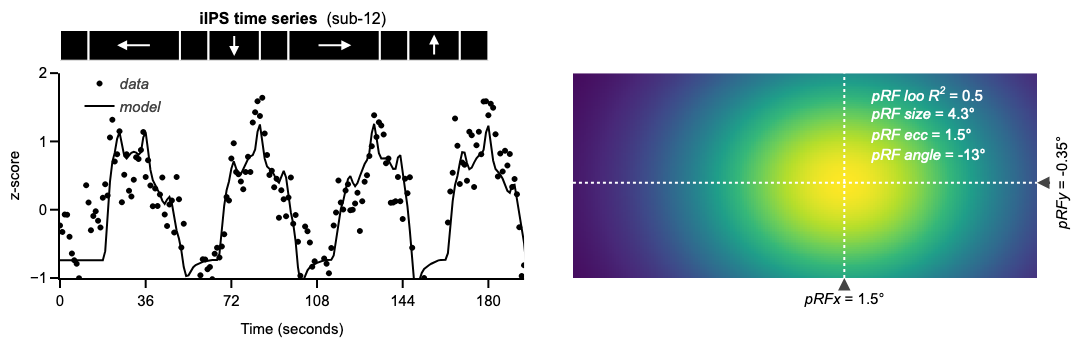

In [55]:
vertex_to_plot = 12045

fig = draw_timeseries(bold_data=bold_data, prf_prediction=prf_pred_data, vox_data=vertex_to_plot, vox_model=vertex_to_plot)
fig.write_image('/Users/uriel/Downloads/time_seris.pdf')
fig.show()

In [73]:
# # top_20_df = sorted_df.head(20)
# top_20_df = sorted_df.iloc[300:500]
# for num_vert in top_20_df.num_vert:
#     print(num_vert)
#     vertex_to_plot = num_vert

#     fig = draw_timeseries(bold_data=bold_data, prf_prediction=prf_pred_data, vox_data=vertex_to_plot, vox_model=vertex_to_plot)
#     fig.show()

In [29]:
tsv_dir ='{}/{}/derivatives/pp_data/{}/{}/prf/tsv'.format(main_dir, 
                                                                project_dir, 
                                                                subject,
                                                         format_)

# data = pd.read_table('{}/{}_css-prf_derivatives.tsv'.format(tsv_dir,subject))
df_pRF = pd.read_table('{}/{}_css-all_derivatives.tsv'.format(tsv_dir,subject))

In [36]:
df_pRF.columns

Index(['prf_rsq', 'prf_ecc', 'polar_real', 'polar_imag', 'prf_size',
       'amplitude', 'baseline', 'prf_x', 'prf_y', 'hrf_1', 'hrf_2', 'prf_n',
       'prf_loo_r2', 'slope', 'intercept', 'rvalue', 'pvalue', 'stderr', 'trs',
       'corr_pvalue_5pt', 'corr_pvalue_1pt', 'n_neighbor', 'pcm_median',
       'vert_geo_dist_median', 'vert_prf_dist_median', 'vert_area', 'roi',
       'subject', 'hemi', 'num_vert'],
      dtype='object')

In [64]:
rois =  ['iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS']
# rois =  ['V1']

# Filtrer les lignes où la colonne 'roi' appartient à la liste 'rois'
filtered_df = df_pRF[df_pRF['roi'].isin(rois)]

# Trier le DataFrame filtré par la colonne 'prf_loo_r2' en ordre décroissant
sorted_df = filtered_df.sort_values(by='prf_loo_r2', ascending=False)

# Sélectionner les 20 meilleures valeurs de 'prf_loo_r2'
top_20_df = sorted_df.head(20)

In [69]:
sorted_df

,prf_rsq,prf_ecc,polar_real,polar_imag,prf_size,amplitude,baseline,prf_x,prf_y,hrf_1,...,corr_pvalue_1pt,n_neighbor,pcm_median,vert_geo_dist_median,vert_prf_dist_median,vert_area,roi,subject,hemi,num_vert
27070,0.789400,3.248012,0.993289,-0.041669,4.909033,2.864932e-01,-1.183886,3.226764,-0.142301,1.618586,...,0.000000,3670.0,4.874931,15.581011,3.196150,1.054328,sIPS,sub-12,hemi-L,33341
27235,0.785361,2.912198,0.988733,-0.141443,4.160712,3.027631e-01,-1.172402,2.878720,-0.416643,1.406641,...,0.000000,3805.0,4.644801,15.032626,3.236442,0.745356,sIPS,sub-12,hemi-L,36012
37591,0.767542,27.928513,0.804119,0.562412,20.237709,3.766094e-01,-1.239986,22.206620,15.850394,0.869506,...,0.000000,NaN,NaN,NaN,NaN,0.657976,mPCS,sub-12,hemi-L,82392
37583,0.765565,17.649471,0.705669,0.690818,16.918507,2.979227e-01,-1.235064,13.000717,11.390448,0.727225,...,0.000000,2084.0,1.206736,14.714068,12.193276,0.516165,mPCS,sub-12,hemi-L,82382
27236,0.791356,2.889481,0.950472,-0.303977,4.137355,2.982011e-01,-1.184936,2.742045,-0.891755,1.028779,...,0.000000,3752.0,4.716837,15.363659,3.257195,0.870563,sIPS,sub-12,hemi-L,36013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24976,0.166146,12.982428,-0.114438,-0.092856,4.697378,9.944023e+16,-0.182079,-2.343918,1.512622,1.102558,...,0.253629,NaN,NaN,NaN,NaN,0.541845,sIPS,sub-12,hemi-L,11836
27452,0.207044,2.368287,-0.193942,-0.907298,1.334297,-7.769863e-02,0.167015,0.031338,-2.061324,-0.060829,...,0.018319,NaN,NaN,NaN,NaN,0.229701,sIPS,sub-12,hemi-L,38488
72797,0.224493,4.002418,-0.083812,-0.447900,1.432305,-6.371330e+01,0.155782,-1.472512,-1.690104,321.178700,...,0.149017,NaN,NaN,NaN,NaN,0.378946,sPCS,sub-12,hemi-R,84413
24178,0.192241,20.657840,-0.007006,-0.340902,6.699680,1.544646e+18,-18.626724,-10.967360,-0.011811,14.563375,...,0.118613,NaN,NaN,NaN,NaN,0.704009,iIPS,sub-12,hemi-L,23126


In [45]:
df_pRF.loc[(df_pRF.num_vert==12045), 'roi']

22625    iIPS
61648    iIPS
Name: roi, dtype: object

In [46]:
df_pRF.loc[(df_pRF.num_vert==12045), 'prf_loo_r2']

22625    0.504306
61648    0.123694
Name: prf_loo_r2, dtype: float64

In [47]:
df_pRF.loc[(df_pRF.num_vert==12045)]

,prf_rsq,prf_ecc,polar_real,polar_imag,prf_size,amplitude,baseline,prf_x,prf_y,hrf_1,...,corr_pvalue_1pt,n_neighbor,pcm_median,vert_geo_dist_median,vert_prf_dist_median,vert_area,roi,subject,hemi,num_vert
22625,0.739580,1.597858,0.994479,-0.034635,4.168333,0.104742,-0.861053,1.589135,-0.052301,2.968602,...,0.000000e+00,3427.0,2.078809,15.532948,7.472043,0.290617,iIPS,sub-12,hemi-L,12045
61648,0.295831,270.632970,0.703703,0.343868,1190.929200,0.134364,-0.569918,263.128100,-37.386800,-1.749543,...,5.974075e-07,NaN,NaN,NaN,NaN,0.583987,iIPS,sub-12,hemi-R,12045
